In [22]:
import re
import sqlite3
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from datetime import datetime
from transformers import AutoTokenizer, BertForSequenceClassification, pipeline

torch.cuda.is_available()

True

In [23]:
conn = sqlite3.connect('../letters.db')
cursor = conn.cursor()

res = cursor.execute("""
    select * from letters 
    where gestora = 'Guepardo'
""")

res.fetchone()

(1,
 'Guepardo',
 'Relatório de Gestão 3º Trimestre - 2024',
 '2024-07-01',
 'https://www.guepardoinvest.com.br/Carta-111-Carta-aos-Investidores-3T24.pdf',
 '  Carta aos Investidores                 3º Trimestre de 2024   \n  \n   \n               1   \n     \nRenda Variável: a renda perpétua   \nCom o aumento das taxas de juros nos últimos anos, criou-se uma imagem de que os ativos de renda \nfixa e renda variável são antagônicos e andam em direções opostas. Nós da Guepardo discordamos nesse aspecto, \numa vez que ambos estarão sujeitos a marcação a mercado e terão volatilidade de preços ao longo do tempo. \nAbaixo explicaremos a relação entre a renda fixa e renda variável:   \n   \nPrimeiro vamos pensar em uma NTN-B que paga cupom semestral. Quando vemos o fluxo de \npagamentos, vemos algo como o gráfico abaixo:   \n   \nComo na renda fixa temos todas as informações do fluxo, encontramos a taxa exata do investimento. Já \nna renda variável, o fluxo se assemelha ao gráfico abaixo:   \

In [24]:
letters = []
cols = [col[0] for col in res.description]

for row in res.fetchall():
    letters.append(dict(zip(cols, row))) 

print(cols)
print(letters[0])

['id', 'gestora', 'title', 'date', 'url', 'content']
{'id': 2, 'gestora': 'Guepardo', 'title': 'Relatório de Gestão 2º Trimestre - 2024', 'date': '2024-04-01', 'url': 'https://www.guepardoinvest.com.br/Carta-110-Carta-aos-Investidores-2T24.pdf', 'content': ' \n               1 \nCarta aos Investidores       2º Trimestre de 2024 \n \n \n \nPreço versus Valor \n \nNesta carta explicaremos a diferença entre o preço do ativo (cotação na BOLSA DE VALORES) e do valor \nintrínseco do ativo (valor que julgamos ser o justo) e como a volatilidade da cotação cria a oportunidade de \ninvestirmos com uma boa margem de segurança.  \nEsse modelo de gráfico já foi utilizado em cartas anteriores, porém entendemos que é uma das formas mais \nsimples de compreender a diferença entre a variação do preço do ativo e do valor justo estimado pela gestora. \nOs dois gráficos abaixo são de empresas investidas nos fundos da Guepardo. A linha em azul é o valor que \njulgamos ser o justo da empresa trazido a valor

In [25]:
conn.close()

In [26]:
tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
model = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

finbert = pipeline(task='text-classification', model=model, tokenizer=tokenizer, top_k=None)

Device set to use cuda:0


In [27]:
text = letters[0]['content']
text = text.replace('[Música]', ' ')

In [55]:
def generate_chunks(text: str, min_size: int=5, max_size: int=250, punctuation: bool=False) -> list[str]:
    if not text:
        return []
    
    chunks = []
    
    if punctuation:
        sentences = re.split(r'(?<=[.!?])\s+', text)
        
        for sentence in sentences:
            if len(sentence) >= min_size:
                if len(sentence) > 512:
                    current_chunk = []
                    chunk_size = 500

                    words = sentence.split()
                    overlap_words = 5
                    
                    for word in words:
                        current_chunk.append(word)
                        current_text = ' '.join(current_chunk)
                        
                        if len(current_text) >= chunk_size and len(current_chunk) > overlap_words:
                            chunks.append(current_text)
                            current_chunk = current_chunk[-overlap_words:]
                    
                    if current_chunk:
                        final_text = ' '.join(current_chunk)
                        if len(final_text) >= min_size:
                            chunks.append(final_text)
                else:
                    chunks.append(sentence.strip())
    else:
        start = 0
        
        while start < len(text):
            end = min(start + max_size, len(text))
            
            if end < len(text) and text[end] != ' ':
                space_index = text.rfind(' ', start, end)
                if space_index != -1:
                    end = space_index
            
            chunks.append(text[start:end].strip())
            start = end + 1
    
    return chunks

In [54]:
for i, chunk in enumerate(generate_chunks(text, punctuation=True), 1):
    print(f"Chunk {i}: {chunk}")


In [56]:
def neutral_sentiment_score(scores: list[list[dict]]) -> int:
    score_sums = defaultdict(float)
    count = defaultdict(int)

    for sentence_scores in scores:
        labels = [entry["label"] for entry in sentence_scores]
        scores = np.array([entry["score"] for entry in sentence_scores])

        for i, label in enumerate(labels):
            score_sums[label] += scores[i]
            count[label] += 1

    avg_scores = {label: score_sums[label] / count[label] for label in score_sums}

    final_score = (avg_scores['POSITIVE'] - avg_scores['NEGATIVE'] + 1) / 2 * 100

    return int(final_score)

In [57]:
def sentiment_score(scores: list[list[dict]]) -> int:
    total_pos = 0.0
    total_neg = 0.0

    for chunk in scores:
        p_pos = [x['score'] for x in chunk if x['label'] == 'POSITIVE'][0]
        p_neg = [x['score'] for x in chunk if x['label'] == 'NEGATIVE'][0]

        total_pos += p_pos
        total_neg += p_neg

    sum_pos_neg = total_pos + total_neg

    if sum_pos_neg == 0:
        return 50

    p_pos = total_pos / sum_pos_neg
    p_neg = total_neg / sum_pos_neg

    final_score = (p_pos - p_neg + 1) / 2 * 100

    return int(final_score)

In [58]:
for letter in letters:
    text = letter['content']

    chunks = generate_chunks(text, punctuation=True)

    if not chunks:
        continue
    
    chunk_count = defaultdict(int)

    results = finbert(chunks)

    for res in results:
        highest_label = max(res, key=lambda x: x['score'])['label']
        chunk_count[highest_label] += 1

    if chunk_count['POSITIVE'] + chunk_count['NEGATIVE'] == 0:
        sentiment_balance = None
    else:
        raw_balance = (chunk_count['POSITIVE'] - chunk_count['NEGATIVE']) / (chunk_count['POSITIVE'] + chunk_count['NEGATIVE'])
        sentiment_balance = (raw_balance + 1) / 2 * 100

    letter['sentiment'] = sentiment_score(results)
    letter['sentiment_neutral'] = neutral_sentiment_score(results)
    letter['sentiment_balance'] = int(sentiment_balance)

    print(f"{letter['title']} - Sentiment: ({letter['sentiment']}) / Sentiment Neutral: ({letter['sentiment_neutral']}) / Sentiment Balance: ({letter['sentiment_balance']})")

Relatório de Gestão 2º Trimestre - 2024 - Sentiment: (76) / Sentiment Neutral: (71) / Sentiment Balance: (88)
Relatório de Gestão 1º Trimestre - 2024 - Sentiment: (73) / Sentiment Neutral: (69) / Sentiment Balance: (88)
Relatório de Gestão 4º Trimestre - 2023 - Sentiment: (77) / Sentiment Neutral: (72) / Sentiment Balance: (88)
Relatório de Gestão 3º Trimestre - 2023 - Sentiment: (70) / Sentiment Neutral: (65) / Sentiment Balance: (82)
Relatório de Gestão 2º Trimestre - 2023 - Sentiment: (63) / Sentiment Neutral: (60) / Sentiment Balance: (68)
Relatório de Gestão 1º Trimestre - 2023 - Sentiment: (71) / Sentiment Neutral: (66) / Sentiment Balance: (86)
Carta aos Investidores 1º Trimestre 2022 - Sentiment: (72) / Sentiment Neutral: (66) / Sentiment Balance: (88)
Carta aos Investidores 2º Trimestre 2022 - Sentiment: (69) / Sentiment Neutral: (64) / Sentiment Balance: (81)
Carta aos Investidores 3º Trimestre 2022 - Sentiment: (69) / Sentiment Neutral: (64) / Sentiment Balance: (80)
Carta a

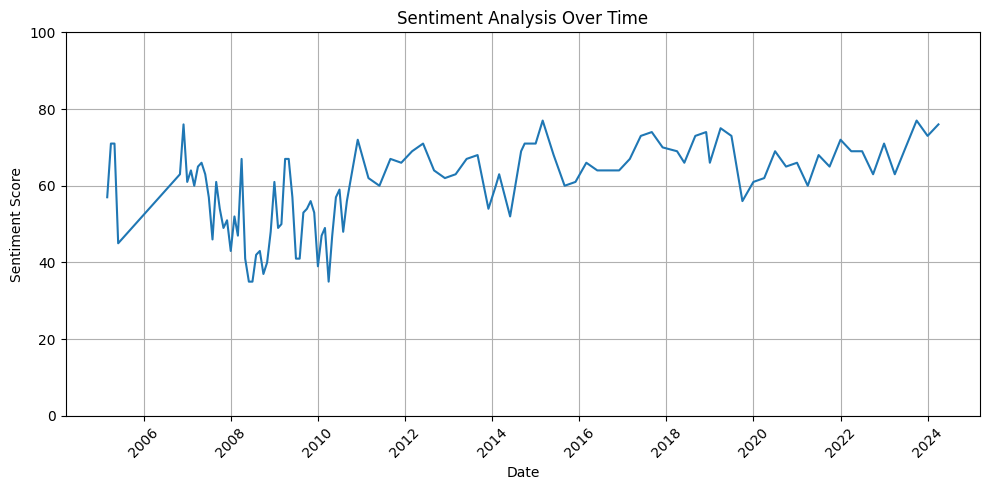

In [ ]:
valid_letters = [letter for letter in letters if letter.get('sentiment') is not None]

sentiment_by_date = {datetime.strptime(letter["date"], "%Y-%m-%d"): letter["sentiment"] for letter in valid_letters}
sorted_sentiment = dict(sorted(sentiment_by_date.items()))

plt.figure(figsize=(10, 5))
plt.plot(sorted_sentiment.keys(), sorted_sentiment.values())
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Over Time")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()